In [322]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
os.getcwd()
from json import load

# MirrorRL

In [337]:
def plot(path, limsup = None):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    for f in all_folders:
        data = pd.read_csv(path+f+"/progress.csv")
        fig = plt.figure(0)
        if limsup != None:
            data = data[data["time_total_s"]<limsup]
        labels = f.split(",")
        eta = labels[1][4:]
        # "time_total_s" "average_reward" "q_error_train" "kl" "entropy"
        plt.plot(data["time_total_s"], data["average_reward"], label=eta)
    plt.legend()
    plt.show()

def plot_all(path, limsup = None, figsize=(10,8), single_pmts = False):

    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    for f in all_folders:
        df = pd.read_csv(path+f+"/progress.csv")
        with open(path+f+"/params.json") as fpms:
            pms = load(fpms)
            lab = "eta = " + str(pms["eta"])[:4]+ ", " + "# neurons = " + str(pms["nb_add_neurone_per_iter"])
        if limsup != None:
            df = df[df["time_total_s"]<limsup]
        if not single_pmts or pms[single_pmts[0]] == single_pmts[1]:
            axs[0, 0].plot(df["time_total_s"], df["average_reward"], label=lab)
            axs[0, 0].set_title("Rewards")
            axs[1, 0].plot(df["time_total_s"], df["q_error_train"], label=lab)
            axs[1, 0].set_title("Loss")
            axs[1, 0].set_yscale('log')
            axs[0, 1].plot(df["time_total_s"], df["kl"], label=lab)
            axs[0, 1].set_title("KL")
            axs[0, 1].set_yscale('log')
            axs[1, 1].plot(df["time_total_s"], df["entropy"], label=lab)
            axs[1, 1].set_title("Entropy")
        plt.legend()
    fig.tight_layout()

In [333]:
def plot_all_av_std(path, limsup = None):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    df = pd.DataFrame()
    for f in all_folders:
        _df = pd.read_csv(path+f+"/progress.csv")
        if limsup != None:
            _df = _df[_df["time_total_s"]<limsup]
        df = pd.concat([df, _df], ignore_index=True)

    df = df[['average_reward', 'q_error_train', "kl", "entropy", "experiment_id", "time_total_s", "time_since_restore", "iterations_since_restore"]]								  
    df = df.pivot_table(index= "iterations_since_restore", aggfunc=[np.mean,  np.std])
    
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["average_reward"]
    dyfit = df["std"]["average_reward"]
    axs[0, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[0, 0].plot(xfit, yfit, color='orange', alpha=0.7)
    axs[0, 0].set_title("Reward")
    
    xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["q_error_train"]
    dyfit = df["std"]["q_error_train"]
    axs[1, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[1, 0].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[1, 0].set_title("Loss")
    axs[1, 0].set_yscale('log')

    xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["kl"]
    dyfit = df["std"]["kl"]
    axs[0, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[0, 1].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[0, 1].set_title("KL") 
    axs[0, 1].set_yscale('log')

    xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["entropy"]
    dyfit = df["std"]["entropy"]
    axs[1, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[1, 1].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[1, 1].set_title("Entropy")

    fig.tight_layout()
    plt.savefig(path.replace("/","_"))
    # return df


### Search good parameters for Cartpole 
Find best $\eta$

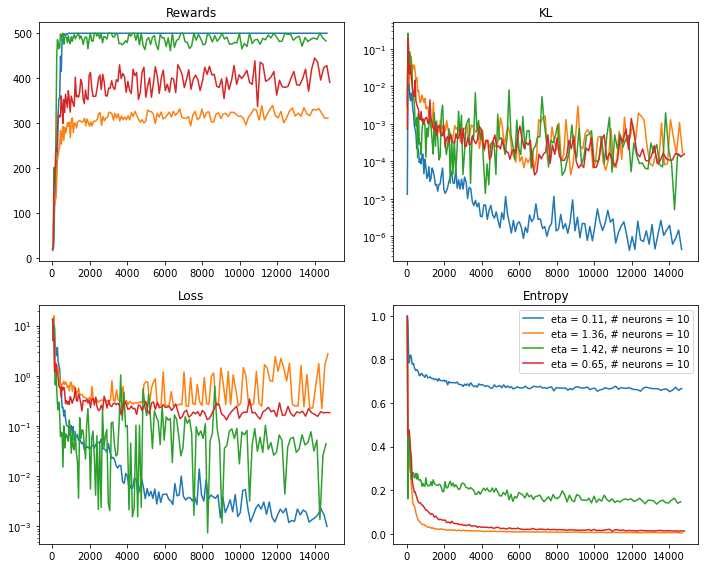

In [343]:
path = "ray_results/run_2022-05-16_15-43-05/"
plot_all(path) 
# plt.savefig(path.replace("/","_"))

Plot average/std across seeds, $\eta=0.1$

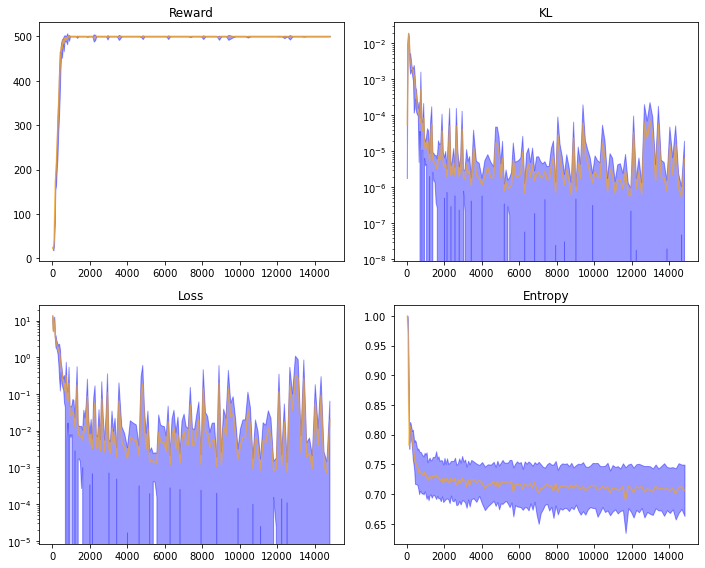

In [335]:
path = "ray_results/run_2022-05-19_14-13-03/"
plot_all_av_std(path,None)

### Search good parameters for Acrobot 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


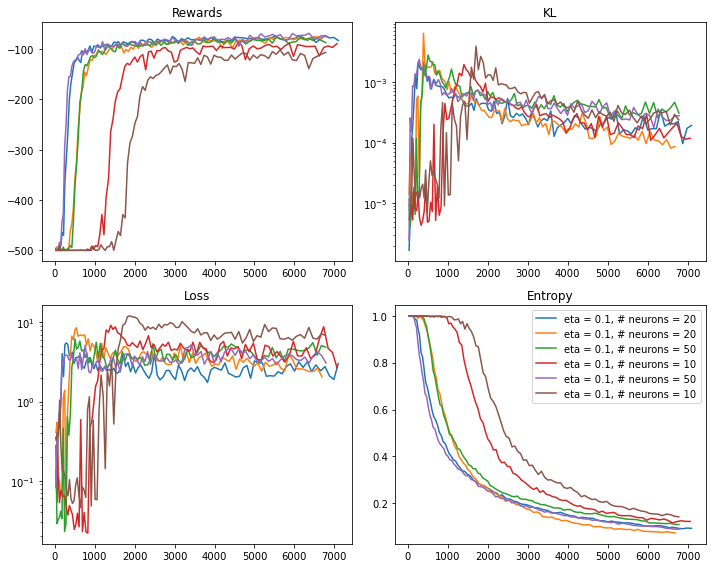

In [364]:
path = "ray_results/run_2022-05-21_12-25-09/"
plot_all(path,figsize=(10,8), single_pmts=["eta", 0.1]) 
plt.savefig(path.replace("/","_"))

In [481]:
def plot_all_av_std_by_pmts(path, limsup = None, time = False):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    df = pd.DataFrame()

    for f in all_folders:
        _df = pd.read_csv(path+f+"/progress.csv")
        with open(path+f+"/params.json") as fpms:
            pms = load(fpms)
        if limsup != None:
            _df = _df[_df["time_total_s"]<limsup]
        _df["eta"] = pms["eta"]
        _df["nb_add_neurone_per_iter"] = pms["nb_add_neurone_per_iter"]
        df = pd.concat([df, _df], ignore_index=True)
    
    df = df[["nb_add_neurone_per_iter", "eta", 'average_reward', 'q_error_train', "kl", "entropy", "experiment_id", "time_total_s", "time_since_restore", "iterations_since_restore"]]								  

    fig, axs = plt.subplots(2, 2, figsize=(15,12))
    for nb in df["nb_add_neurone_per_iter"].unique():
        df_sub = df[df["nb_add_neurone_per_iter"]==nb]
        df_sub = df_sub.pivot_table(index= "iterations_since_restore", aggfunc=[np.mean,  np.std])
        lab = "eta = " + str(pms["eta"])[:4]+ ", " + "# neurons = " + str(nb)

        
        if time:
            xfit = df_sub["mean"]["time_total_s"]
        else:
            xfit = df_sub.index 
        yfit = df_sub["mean"]["average_reward"]
        dyfit = df_sub["std"]["average_reward"]
        axs[0, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, alpha=0.4)
        axs[0, 0].plot(xfit, yfit, alpha=0.7, label=lab)
        axs[0, 0].set_title("Reward")
        
        if time:
            xfit = df_sub["mean"]["time_total_s"]
        else:
            xfit = df_sub.index 
        xfit = df_sub["mean"]["time_total_s"]
        yfit = df_sub["mean"]["q_error_train"]
        dyfit = df_sub["std"]["q_error_train"]
        axs[1, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, alpha=0.4)
        axs[1, 0].plot(xfit, yfit, alpha=0.6, label=lab)
        axs[1, 0].set_title("Loss")
        axs[1, 0].set_yscale('log')

        if time:
            xfit = df_sub["mean"]["time_total_s"]
        else:
            xfit = df_sub.index 
        yfit = df_sub["mean"]["kl"]
        dyfit = df_sub["std"]["kl"]
        axs[0, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, alpha=0.4)
        axs[0, 1].plot(xfit, yfit, alpha=0.6, label=lab)
        axs[0, 1].set_title("KL") 
        axs[0, 1].set_yscale('log')


        if time:
            xfit = df_sub["mean"]["time_total_s"]
        else:
            xfit = df_sub.index
        yfit = df_sub["mean"]["entropy"]
        dyfit = df_sub["std"]["entropy"]
        axs[1, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, alpha=0.4)
        axs[1, 1].plot(xfit, yfit, alpha=0.6, label=lab)
        axs[1, 1].set_title("Entropy")

        fig.tight_layout()
        plt.savefig("MirrorRL_"+path.replace("/","_")+"_by_pmts")
        plt.legend()

        

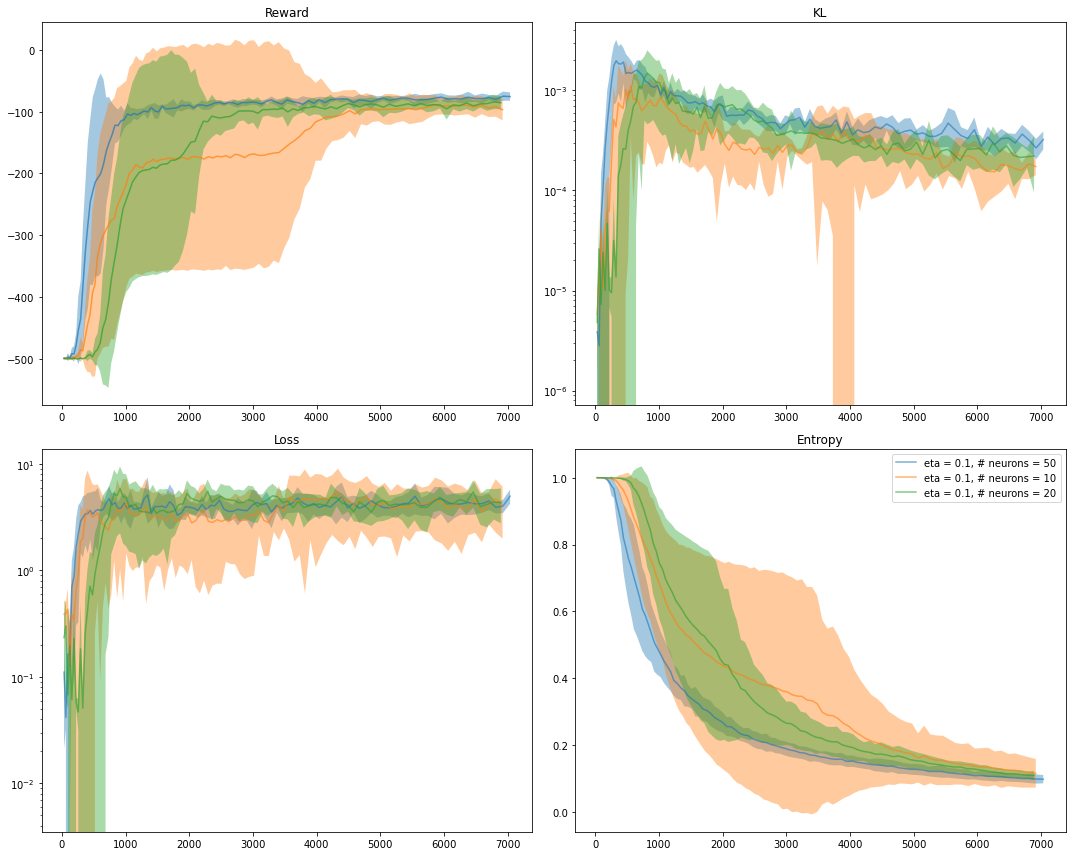

In [482]:
path = "ray_results/run_2022-05-22_21-51-02/"
plot_all_av_std_by_pmts(path, limsup = None, time = True)
plt.savefig("MirrorRL_"+path.replace("/","_")+"_by_pmts")


# A2C

In [464]:
def plot_reward(path, time= False):
    df = pd.read_csv(path+"/data.csv")
    df = df[df["tag"]=="eval_rewards"]
    df = df.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])
    if time:
        xfit = df["mean"]["dw_time_elapsed"]["eval_rewards"]
    else:
        xfit = df.index  
    yfit = df["mean"]["value"]["eval_rewards"]
    dyfit = df["std"]["value"]["eval_rewards"]
    plt.fill_between(xfit, yfit - dyfit, np.minimum(yfit+dyfit,500), color='blue', alpha=0.4)
    plt.plot(xfit, yfit, color='orange', alpha=0.7)
    plt.title("Reward")
    plt.savefig(path.replace("/","_"))

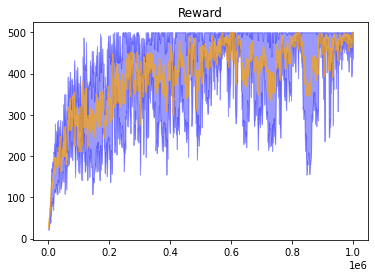

In [465]:
path = "results/solving_cartpole/a2c_cartpole/21/manager_data"
plot_reward(path)

In [460]:
def plot_rlberry_exp(path, time = False):
    df = pd.read_csv(path + "/data.csv")
    df = df[(df["tag"]=="eval_rewards") | (df["tag"]=="loss") | (df["tag"]=="kl") | (df["tag"]=="ent")]
    df = df.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    if time:
       xfit = df["mean"]["dw_time_elapsed"]["eval_rewards"]
    else:
        xfit = df.index  
    yfit = df["mean"]["value"]["eval_rewards"]
    dyfit = df["std"]["value"]["eval_rewards"]
    axs[0, 0].fill_between(xfit, yfit - dyfit, np.minimum(yfit+dyfit,500), color='blue', alpha=0.4)
    axs[0, 0].plot(xfit, yfit, color='orange', alpha=0.4)
    axs[0, 0].set_title("eval_rewards")

    if time:
       xfit = df["mean"]["dw_time_elapsed"]["loss"]
    else:
        xfit = df.index  
    yfit = df["mean"]["value"]["loss"]
    dyfit = df["std"]["value"]["loss"]
    axs[1, 0].fill_between(xfit, yfit - dyfit, yfit+dyfit, color='blue', alpha=0.4)
    axs[1, 0].plot(xfit, yfit, color='orange', alpha=0.4)
    axs[1, 0].set_title("loss")

    if time:
       xfit = df["mean"]["dw_time_elapsed"]["kl"]
    else:
        xfit = df.index  
    yfit = df["mean"]["value"]["kl"]
    dyfit = df["std"]["value"]["kl"]
    axs[0, 1].fill_between(xfit, np.maximum(yfit - dyfit,0), yfit+dyfit, color='blue', alpha=0.4)
    axs[0, 1].plot(xfit, yfit, color='orange', alpha=0.4)
    axs[0, 1].set_title("kl") 

    if time:
       xfit = df["mean"]["dw_time_elapsed"]["ent"]
    else:
        xfit = df.index   
    yfit = df["mean"]["value"]["ent"]
    dyfit = df["std"]["value"]["ent"]
    axs[1, 1].fill_between(xfit, np.maximum(yfit - dyfit,0), yfit+dyfit, color='blue', alpha=0.4)
    axs[1, 1].plot(xfit, yfit, color='orange', alpha=0.4)
    axs[1, 1].set_title("ent")

    fig.tight_layout()
    plt.savefig(path.replace("/","_"))

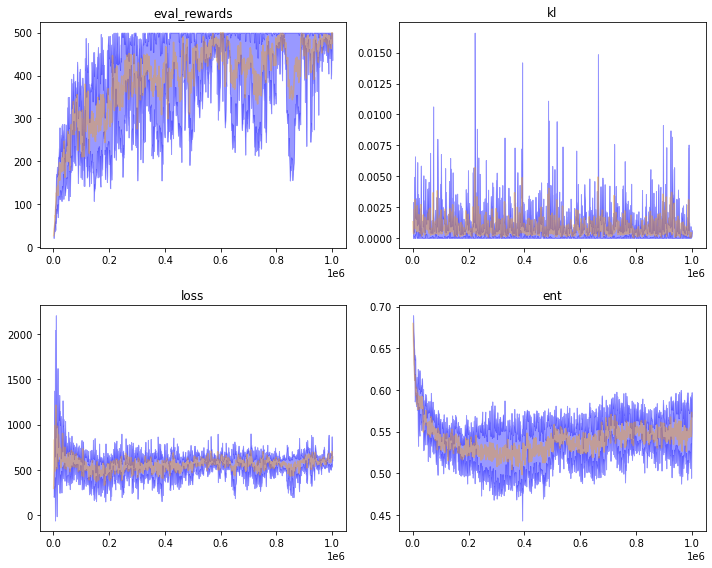

In [461]:
path = "results/solving_cartpole/a2c_cartpole/22/manager_data"
plot_rlberry_exp(path)

In [361]:
path = "results/solving_acrobot/a2c_cartpole/1/manager_data"
# plot_rlberry_exp(path)
df = pd.read_csv(path + "/data.csv")
df["tag"].unique()

array(['episode_rewards', 'total_episodes', 'eval_rewards', 'memory_size'],
      dtype=object)

### DQN

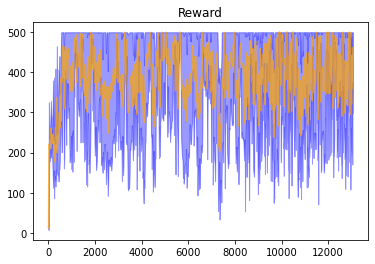

In [424]:
path = "results/solving_cartpole/dqn_cartpole/1/manager_data"
plot_reward(path)

In [425]:
path = "results/solving_cartpole/dqn_cartpole/1/manager_data"
df = pd.read_csv(path + "/data.csv")
df

,name,tag,value,global_step,dw_time_elapsed
0,dqn_cartpole,episode_rewards,24.000000,24,1.910446
1,dqn_cartpole,episode_rewards,15.000000,39,1.910950
2,dqn_cartpole,episode_rewards,37.000000,76,1.912357
3,dqn_cartpole,episode_rewards,36.000000,112,1.914412
4,dqn_cartpole,episode_rewards,43.000000,155,1.916819
...,...,...,...,...,...
5550540,dqn_cartpole,losses/q_loss,16.788536,994996,13170.039052
5550541,dqn_cartpole,losses/q_loss,77.716553,994997,13170.044711
5550542,dqn_cartpole,losses/q_loss,79.576103,994998,13170.050453
5550543,dqn_cartpole,losses/q_loss,66.203499,994999,13170.056016


In [426]:
df.pivot_table(index= "global_step", columns="tag")#, aggfunc=[np.mean,  np.std])

dw_time_elapsed                                              \
tag             buffer_size episode_rewards       epsilon  eval_rewards   
global_step                                                               
1                       NaN             NaN           NaN           NaN   
2                       NaN             NaN           NaN           NaN   
3                       NaN             NaN           NaN           NaN   
4                       NaN             NaN           NaN           NaN   
5                       NaN             NaN           NaN           NaN   
...                     ...             ...           ...           ...   
999995                  NaN             NaN  12860.279562           NaN   
999997                  NaN    13184.248565           NaN           NaN   
999998                  NaN    13170.002991           NaN           NaN   
999999                  NaN             NaN  12860.280649           NaN   
1000000        13063.716734             NaN           NaN  13063.716705   

                                               value                          \
tag         losses/q_loss total_episodes buffer_size episode_rewards epsilon   
global_step                                                                    
1                4.682136            NaN         NaN             NaN     NaN   
2                4.695597            NaN         NaN             NaN     NaN   
3                4.706518            NaN         NaN             NaN     NaN   
4                4.723357            NaN         NaN             NaN     NaN   
5                4.741951            NaN         NaN             NaN     NaN   
...                   ...            ...         ...             ...     ...   
999995                NaN            NaN         NaN             NaN     0.1   
999997                NaN   13184.248569         NaN           500.0     NaN   
999998                NaN   13170.002995         NaN            96.0     NaN   
999999                NaN            NaN         NaN             NaN     0.1   
1000000               NaN            NaN     10000.0             NaN     NaN   

                                                       
tag         eval_rewards losses/q_loss total_episodes  
global_step                                            
1                    NaN      1.088058            NaN  
2                    NaN      0.839752            NaN  
3                    NaN      0.649724            NaN  
4                    NaN      0.510031            NaN  
5                    NaN      0.364540            NaN  
...                  ...           ...            ...  
999995               NaN           NaN            NaN  
999997               NaN           NaN         3789.0  
999998               NaN           NaN         4269.0  
999999               NaN           NaN            NaN  
1000000            437.9           NaN            NaN  

[997135 rows x 12 columns]

In [427]:
df = df[(df["tag"]=="eval_rewards") | (df["tag"]=="losses/q_loss")]
df.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])

mean                                           \
            dw_time_elapsed                      value                 
tag            eval_rewards losses/q_loss eval_rewards losses/q_loss   
global_step                                                            
1                       NaN      4.682136          NaN      1.088058   
2                       NaN      4.695597          NaN      0.839752   
3                       NaN      4.706518          NaN      0.649724   
4                       NaN      4.723357          NaN      0.510031   
5                       NaN      4.741951          NaN      0.364540   
...                     ...           ...          ...           ...   
996000         13030.197734           NaN       375.58           NaN   
997000         13038.408402           NaN       360.94           NaN   
998000         13046.999293           NaN       461.44           NaN   
999000         13055.603770           NaN       446.96           NaN   
1000000        13063.716705           NaN       437.90           NaN   

                        std                                           
            dw_time_elapsed                      value                
tag            eval_rewards losses/q_loss eval_rewards losses/q_loss  
global_step                                                           
1                       NaN      1.509591          NaN      0.125543  
2                       NaN      1.514107          NaN      0.142789  
3                       NaN      1.517558          NaN      0.127091  
4                       NaN      1.526363          NaN      0.128657  
5                       NaN      1.537384          NaN      0.115164  
...                     ...           ...          ...           ...  
996000           194.770450           NaN   176.768682           NaN  
997000           193.689511           NaN   190.437281           NaN  
998000           192.810425           NaN    86.222781           NaN  
999000           191.754997           NaN   117.597398           NaN  
1000000          191.212477           NaN   138.859821           NaN  

[995005 rows x 8 columns]

In [456]:
def plot_rlberry_exp_dqn(path, time=False):

    df = pd.read_csv(path+"/data.csv")
    dfr = df[(df["tag"]=="eval_rewards")]
    dfr = dfr.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])
    fig, (ax1,ax2) = plt.subplots(1, 2,  figsize=(10,4))

    if time:
        xfit = dfr["mean"]["dw_time_elapsed"]["eval_rewards"]
    else:
        xfit  = dfr.index
    yfit = dfr["mean"]["value"]["eval_rewards"]
    dyfit = dfr["std"]["value"]["eval_rewards"]
    ax1.fill_between(xfit, yfit - dyfit, np.minimum(yfit+dyfit,500), color='blue', alpha=0.4)
    ax1.plot(xfit, yfit, color='orange', alpha=0.6)
    ax1.set_title("Reward")


    dfl = df[(df["tag"]=="losses/q_loss")]
    dfl = dfl.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])

    if time:
        xfit = dfl["mean"]["dw_time_elapsed"]["losses/q_loss"]
    else:
        xfit = dfl.index
    yfit = dfl["mean"]["value"]["losses/q_loss"]
    dyfit = dfl["std"]["value"]["losses/q_loss"]
    ax2.fill_between(xfit, np.maximum(0,yfit - dyfit), yfit+dyfit, color='blue', alpha=0.4)
    ax2.plot(xfit, yfit, color='orange', alpha=0.4)
    ax2.set_title("Loss")

    fig.tight_layout()
    plt.savefig(path.replace("/","_"))


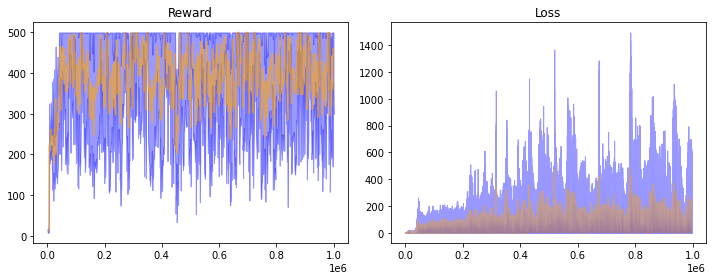

In [459]:
path = "results/solving_cartpole/dqn_cartpole/1/manager_data"
plot_rlberry_exp_dqn(path)

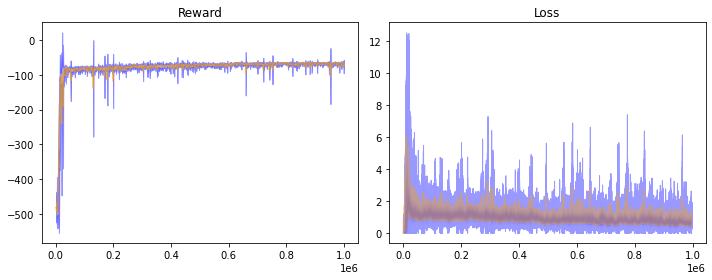

In [458]:
path = "results/solving_acrobot/dqn_acrobot/1/manager_data"
plot_rlberry_exp_dqn(path)